In [180]:
from Data.Dataset import LatentFMRIDataset
import matplotlib.pylab as pl
import ot.plot
import ot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
import torch
from tqdm import tqdm

In [78]:
nyu_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_all'
um1_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_all'
merged_set_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_UM1_merged'

In [79]:
nyu_data = LatentFMRIDataset(data_dir=nyu_dataset_directory).get_all_items()
um1_data = LatentFMRIDataset(data_dir=um1_dataset_directory).get_all_items()

In [80]:
X_nyu = nyu_data['X']
y_nyu = nyu_data['y']
X_um1 = um1_data['X']
y_um1 = um1_data['y']
X_nyu, y_nyu = shuffle(X_nyu, y_nyu, random_state=41)
X_um1, y_um1 = shuffle(X_um1, y_um1, random_state=41)

X_nyu = X_nyu.reshape((X_nyu.shape[0], -1))
X_um1 = X_um1.reshape((X_um1.shape[0], -1))

X_nyu.shape, y_nyu.shape, X_um1.shape, y_um1.shape

((29575, 1152), (29575,), (23600, 1152), (23600,))

Train on X_nyu, 80% of X_um1
Test on 20% X_um1

In [81]:
# Train test split of UM1
X_um1_train = X_um1[:int(0.8*X_um1.shape[0])]
X_um1_test = X_um1[int(0.8*X_um1.shape[0]):]
y_um1_train = y_um1[:int(0.8*y_um1.shape[0])]
y_um1_test = y_um1[int(0.8*y_um1.shape[0]):]
X_um1_train.shape, y_um1_train.shape, X_um1_test.shape, y_um1_test.shape

((18880, 1152), (18880,), (4720, 1152), (4720,))

# Fit Gaussians to the NYU features

In [117]:
# Approximate the feature distributions with a superposition of 2 gaussians
gm = GaussianMixture(n_components=2, covariance_type='diag', random_state=41).fit(X_nyu)
gm.means_.shape

(2, 1152)

In [118]:
means = gm.means_.T
variances = gm.covariances_.T

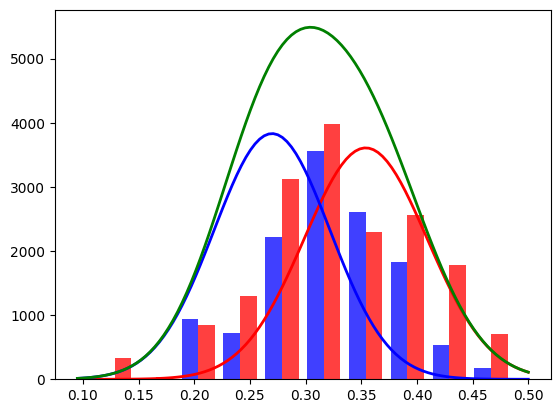

In [119]:
from scipy.stats import norm

index_to_plot = 799

plt.hist(x=(X_nyu[y_nyu == 1, index_to_plot], X_nyu[y_nyu == 2, index_to_plot]), color=['blue', 'red'], alpha=0.75)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, means[index_to_plot, 0], np.sqrt(variances[index_to_plot, 0]))
p = p  * 500
p2 = norm.pdf(x, means[index_to_plot, 1], np.sqrt(variances[index_to_plot, 1]))
p2 = p2 * 500
p_superposition = p + p2
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'b', linewidth=2)
plt.plot(x, p_superposition, 'g', linewidth=2)
plt.show()

# Fit Gaussians to the UM1 features

In [120]:
# Approximate the feature distributions with a superposition of 2 gaussians
gm_um1 = GaussianMixture(n_components=2, covariance_type='diag', random_state=41).fit(X_um1_train)
gm_um1.means_.shape, gm_um1.covariances_.shape

((2, 1152), (2, 1152))

In [121]:
means_um1 = gm_um1.means_.T
variances_um1 = gm_um1.covariances_.T

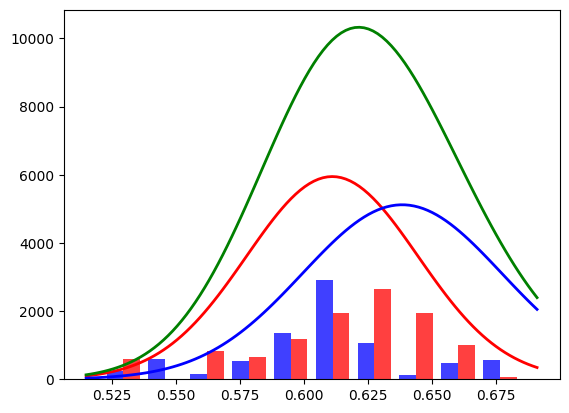

In [126]:
from scipy.stats import norm

index_to_plot = 3

plt.hist(x=(X_um1_train[y_um1_train == 1, index_to_plot], X_um1_train[y_um1_train == 2, index_to_plot]), color=['blue', 'red'], alpha=0.75)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, means_um1[index_to_plot, 0], np.sqrt(variances_um1[index_to_plot, 0]))
p = p  * 500
p2 = norm.pdf(x, means_um1[index_to_plot, 1], np.sqrt(variances_um1[index_to_plot, 1]))
p2 = p2 * 500
p_superposition = p + p2
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'b', linewidth=2)
plt.plot(x, p_superposition, 'g', linewidth=2)
plt.show()

# Fit Gaussians to the test set

In [127]:
# Approximate the feature distributions with a superposition of 2 gaussians
gm_test = GaussianMixture(n_components=2, covariance_type='diag', random_state=41).fit(X_um1_test)
gm_test.means_.shape, gm_test.covariances_.shape

((2, 1152), (2, 1152))

In [128]:
means_test = gm_test.means_.T
variances_test = gm_test.covariances_.T

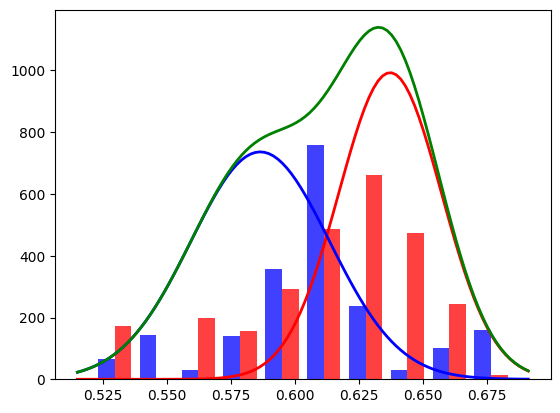

In [131]:
from scipy.stats import norm

index_to_plot = 3

plt.hist(x=(X_um1_test[y_um1_test == 1, index_to_plot], X_um1_test[y_um1_test == 2, index_to_plot]), color=['blue', 'red'], alpha=0.75)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, means_test[index_to_plot, 0], np.sqrt(variances_test[index_to_plot, 0]))
p = p  * 50
p2 = norm.pdf(x, means_test[index_to_plot, 1], np.sqrt(variances_test[index_to_plot, 1]))
p2 = p2 * 50
p_superposition = p + p2
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'b', linewidth=2)
plt.plot(x, p_superposition, 'g', linewidth=2)
plt.show()

In [135]:
p_superposition.shape

(100,)

# Compute the optimal transport plan: UM1 -> NYU (train)

100%|██████████| 1152/1152 [00:01<00:00, 810.26it/s]


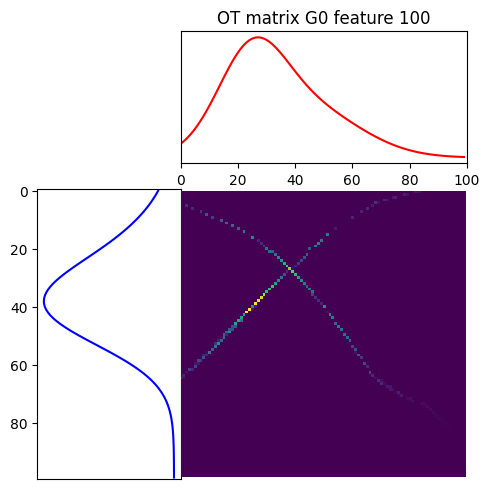

In [186]:
n_bins = 100
index_to_plot = 100
USE_SINKHORN = False

if USE_SINKHORN:
    S_plans = np.zeros(shape=(1152, 100, 100))
else:
    EMD_plans = np.zeros(shape=(1152, 100, 100))

for feature_index in tqdm(range(1152)):
    xmin, xmax = np.min(X_nyu[:, feature_index]), np.max(X_nyu[:, feature_index])
    x = np.linspace(xmin, xmax, n_bins)
    p_nyu = norm.pdf(x, means[feature_index, 0], np.sqrt(variances[feature_index, 0]))
    p2_nyu = norm.pdf(x, means[feature_index, 1], np.sqrt(variances[feature_index, 1]))
    p_superposition_nyu = p_nyu + p2_nyu
    
    xmin, xmax = np.min(X_um1[:, feature_index]), np.max(X_um1[:, feature_index])
    x = np.linspace(xmin, xmax, n_bins)
    p_um1 = norm.pdf(x, means_um1[feature_index, 0], np.sqrt(variances_um1[feature_index, 0]))
    p2_um1 = norm.pdf(x, means_um1[feature_index, 1], np.sqrt(variances_um1[feature_index, 1]))
    p_superposition_um1 = p_um1 + p2_um1
    
    M = ot.dist(p_superposition_nyu.reshape((n_bins, 1)), p_superposition_um1.reshape((n_bins, 1)))
    M /= M.max()
    
    if USE_SINKHORN:
        lambd = 1e-2
        Gs = ot.sinkhorn(p_superposition_um1, p_superposition_nyu, M, lambd, verbose=True)
        S_plans[feature_index] = Gs
        if feature_index == index_to_plot:
            pl.figure(4, figsize=(5, 5))
            ot.plot.plot1D_mat(p_superposition_um1, p_superposition_nyu, Gs, 'OT matrix Sinkhorn')
            pl.show()
    else:
        G0 = ot.emd(p_superposition_um1 / p_superposition_um1.sum(), p_superposition_nyu / p_superposition_nyu.sum(), M)
        EMD_plans[feature_index] = G0
        if feature_index == index_to_plot:
            pl.figure(3, figsize=(5, 5))
            ot.plot.plot1D_mat(p_superposition_um1, p_superposition_nyu, G0, f'OT matrix G0 feature {feature_index}')


In [190]:
# Ötlet 1: minden mintára: hova transzformálná a transport. Ez nem veszi figyelembe a class labelt
# Ötlet 2: Valahogy a class labelt is figyelembe venni, itt már van olyan metódus a pot-ban aminél meg lehet adni, az mit csinál vele?
# Ötlet 3: valahogy a distance costba nem lehetne belevenni a labelt?
# Ötlet 4: A két gauss illesztése helyett classonként 1-1 gauss illesztése

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00017662, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     